# Caracterización epidemiologica 
En este codigo se caracterizan las dominancias, distribucion de clados, entre otros factores para caracterizar las caracteristicas epidemiologicas del tamaño muestral inicial

In [1]:
import pandas as pd
import inspect
import multiprocessing as mp
import matplotlib.pyplot as plt
import numpy as np
from Bio import Phylo
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.dates as mdates
from scipy.signal import argrelextrema # minimos locales
from matplotlib.patches import FancyBboxPatch
import multiprocessing as mp
import matplotlib.gridspec as gridspec
from scipy.signal import savgol_filter
from math import pi

## Identificación taxonomica

In [2]:
df = pd.read_csv('/home/ferambriz/Programs/ncov_600_mil/data/custom.metadata.tsv', sep = '\t')
df = df[df['strain'].str.startswith('hCoV-19/')]
df['host'] = df['host'].replace({'Humano':'Human'})

#df['date'] = pd.to_datetime(df['date'])
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')
df['año'] = df['date'].dt.year
df['mes'] = df['date'].dt.month

df.iloc[0:2]

,strain,virus,gisaid_epi_isl,genbank_accession,date,region,country,division,location,region_exposure,...,originating_lab,submitting_lab,authors,url,title,paper_url,date_submitted,purpose_of_sequencing,año,mes
0,hCoV-19/otter/USA/GA-21-011485-003/2021,betacoronavirus,EPI_ISL_3152719,?,2021-04-16,North America,USA,Georgia,NaN,North America,...,University of Georgia College of Veterinary Me...,"Diagnostic Virology Laboratory, National Veter...","Kerrie M. Franzen, Mary L. Killian, Emily R. L...",https://www.gisaid.org/,?,?,2021-07-30,?,2021.0,4.0
1,hCoV-19/otter/USA/GA-21-011485-005/2021,betacoronavirus,EPI_ISL_3152720,?,2021-04-16,North America,USA,Georgia,NaN,North America,...,University of Georgia College of Veterinary Me...,"Diagnostic Virology Laboratory, National Veter...","Kerrie M. Franzen, Mary L. Killian, Emily R. L...",https://www.gisaid.org/,?,?,2021-07-30,?,2021.0,4.0


In [3]:
clades = pd.read_csv('/home/ferambriz/Programs/ncov_600_mil/results/custom-build/nextclade_qc.tsv', sep = '\t')
clades.head()

/tmp/ipykernel_26963/1217764662.py:1: DtypeWarning: Columns (6,27,31,55,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  clades = pd.read_csv('/home/ferambriz/Programs/ncov_600_mil/results/custom-build/nextclade_qc.tsv', sep = '\t')


,index,seqName,clade,Nextclade_pango,partiallyAliased,clade_nextstrain,clade_who,clade_display,qc.overallScore,qc.overallStatus,...,qc.frameShifts.status,qc.stopCodons.stopCodons,qc.stopCodons.totalStopCodons,qc.stopCodons.score,qc.stopCodons.status,totalPcrPrimerChanges,pcrPrimerChanges,failedGenes,warnings,errors
0,0,otter/USA/GA-21-011485-003/2021,20I,B.1.1.7,B.1.1.7,20I,Alpha,20I (Alpha),62.673611,mediocre,...,good,NaN,0,0,good,5,"ChinaCDC_N_F:G28881A;G28882A;G28883C,ChinaCDC_...",NaN,NaN,NaN
1,3,otter/USA/GA-21-011485-011/2021,20I,B.1.1.7,B.1.1.7,20I,Alpha,20I (Alpha),62.673611,mediocre,...,good,NaN,0,0,good,5,"ChinaCDC_N_F:G28881A;G28882A;G28883C,ChinaCDC_...",NaN,NaN,NaN
2,2,otter/USA/GA-21-011485-009/2021,20I,B.1.1.7,B.1.1.7,20I,Alpha,20I (Alpha),62.673611,mediocre,...,good,NaN,0,0,good,5,"ChinaCDC_N_F:G28881A;G28882A;G28883C,ChinaCDC_...",NaN,NaN,NaN
3,1,otter/USA/GA-21-011485-007/2021,20I,B.1.1.7,B.1.1.7,20I,Alpha,20I (Alpha),69.444444,mediocre,...,good,NaN,0,0,good,5,"ChinaCDC_N_F:G28881A;G28882A;G28883C,ChinaCDC_...",NaN,NaN,NaN
4,4,otter/USA/FL-21-025190-002/2021,21A,B.1.617.2,B.1.617.2,21A,Delta,21A (Delta),0.173611,good,...,good,NaN,0,0,good,1,ChinaCDC_N_F:G28881T,NaN,NaN,NaN


# esta seccion solo correrla na vez

In [51]:
def match_clade(strain):
    s = strain.split('hCoV-19/')
    if s[1] in list(clades['seqName']):
        return list(clades[clades['seqName']== s[1]]['clade'])[0]
    else:
        return 'NaN'
        
pool = mp.Pool(mp.cpu_count())
df['clade'] = pool.map(match_clade, df['strain'])
pool.close()

df_agrupado = pd.DataFrame(df.groupby(['año', 'mes', 'clade']).size())
df_agrupado

0
año    mes  clade          
2010.0 12.0 19B           2
2013.0 7.0  NaN           1
2019.0 6.0  NaN           1
       10.0 19A           1
       12.0 19A          20
...                      ..
2023.0 9.0  23C           2
            23D          10
            23E           8
            23F          46
            recombinant   4

[754 rows x 1 columns]

In [52]:
def match_clade2(strain):
    s = strain.split('hCoV-19/')
    if s[1] in list(clades['seqName']):
        return list(clades[clades['seqName']== s[1]]['clade_who'])[0]
    else:
        return 'NaN'
        
pool = mp.Pool(mp.cpu_count())
df['clade_who'] = pool.map(match_clade2, df['strain'])
pool.close()

In [55]:
df_agrupado.reset_index(inplace =  True)

In [57]:
df_agrupado = df_agrupado.astype(str)
df_agrupado['año'] = df_agrupado['año'].str.replace('.0', '', regex=False)
df_agrupado['mes'] = df_agrupado['mes'].str.replace('.0', '', regex=False)
df_agrupado

,año,mes,clade,0
0,2010,12,19B,2
1,2013,7,NaN,1
2,2019,6,NaN,1
3,2019,10,19A,1
4,2019,12,19A,20
...,...,...,...,...
749,2023,9,23C,2
750,2023,9,23D,10
751,2023,9,23E,8
752,2023,9,23F,46


In [60]:
df.to_csv('../../Data/metadata_clades.tsv', sep = '\t', index = False)
df_agrupado.to_csv('../../Data/CountCladesV2Time.tsv', sep = '\t', index = False)

## Extract RF clade distribution

In [4]:
df = pd.read_csv('../../Data/CountCladesV2Time.tsv', sep = '\t')

def to_date(año, mes):
    return str(año) + '/' + str(mes)
df['date'] = list(map(to_date, df['año'], df['mes']))

df

,año,mes,clade,0,date
0,2010,12,19B,2,2010/12
1,2013,7,NaN,1,2013/7
2,2019,6,NaN,1,2019/6
3,2019,10,19A,1,2019/10
4,2019,12,19A,20,2019/12
...,...,...,...,...,...
749,2023,9,23C,2,2023/9
750,2023,9,23D,10,2023/9
751,2023,9,23E,8,2023/9
752,2023,9,23F,46,2023/9


In [5]:
df_RF = df.groupby(['año', 'mes']).sum().reset_index()
lst = []
for a,m,value in zip(df_RF['año'], df_RF['mes'], df_RF['0']):
    df_i = df[(df['año'] == a) & (df['mes']==m)]
    rf_i = list(df_i['0']/value)
    lst.append(rf_i)
lst = [elemento for sublista in lst for elemento in sublista]
df['RF'] = lst

df.columns = ['year', 'month', 'clone_id', 'count', 'timepoint','clonal_prev']
df

,year,month,clone_id,count,timepoint,clonal_prev
0,2010,12,19B,2,2010/12,1.000000
1,2013,7,NaN,1,2013/7,1.000000
2,2019,6,NaN,1,2019/6,1.000000
3,2019,10,19A,1,2019/10,1.000000
4,2019,12,19A,20,2019/12,0.833333
...,...,...,...,...,...,...
749,2023,9,23C,2,2023/9,0.021978
750,2023,9,23D,10,2023/9,0.109890
751,2023,9,23E,8,2023/9,0.087912
752,2023,9,23F,46,2023/9,0.505495


In [6]:
df.to_csv('../../Data/CountCladesV2Time2.tsv', sep = '\t', index = False)

## Plot clade distribution

In [7]:
df = pd.read_csv('../../Data/CountCladesV2Time2.tsv',sep='\t')

# Preprocess the 'timepoint' column
df['timepoint'] = df['timepoint'].str.replace('.0', '', regex=False)

# Convert the preprocessed 'timepoint' column to datetime
df['timepoint'] = pd.to_datetime(df['timepoint'], format='%Y/%m')
df

,year,month,clone_id,count,timepoint,clonal_prev
0,2010,12,19B,2,2010-12-01,1.000000
1,2013,7,NaN,1,2013-07-01,1.000000
2,2019,6,NaN,1,2019-06-01,1.000000
3,2019,10,19A,1,2019-10-01,1.000000
4,2019,12,19A,20,2019-12-01,0.833333
...,...,...,...,...,...,...
749,2023,9,23C,2,2023-09-01,0.021978
750,2023,9,23D,10,2023-09-01,0.109890
751,2023,9,23E,8,2023-09-01,0.087912
752,2023,9,23F,46,2023-09-01,0.505495


In [8]:
df_pivot = df.pivot(index = 'timepoint', columns = 'clone_id', values = 'clonal_prev')

In [9]:
# Definir los colores manualmente
colores = {
    'nan': 'gray',
    np.nan : '#535F68',
    '19A': '#117A65',
    '20B': '#ff7f0e',
    '20A': '#2ca02c',
    '19B': '#d62728',
    'recombinant': '#9467bd',
    '21J': '#45B39D',
    '20D': '#e377c2',
    '21K': '#7f7f7f',
    '20C': '#bcbd22',
    '21A': '#17becf',
    '20E': '#1c9099',
    '22E': '#a6cee3',
    '22B': '#1f78b4',
    '21L': '#b2df8a',
    '22D': '#33a02c',
    '20I': '#fb9a99',
    '21I': '#e31a1c',
    '22F': '#fdbf6f',
    '22A': '#ff7f00',
    '20H': '#cab2d6',
    '23D': '#6a3d9a',
    '23A': '#ffff99',
    '20J': '#b15928',
    '20G': '#fbb4ae',
    '22C': '#b3cde3',
    '21H': '#ccebc5',
    '23C': '#decbe4',
    '21D': '#fed9a6',
    '21M': '#ffffcc',
    '21F': '#e5d8bd',
    '23E': '#fddaec',
    '21G': '#f2f2f2',
    '23B': '#393b79',
    '21C': '#5254a3',
    '20F': '#6b6ecf',
    '21E': '#9c9ede',
    '21B': '#637939',
    '23F': '#58D68D'
}

# Summarize epidemiologic
desde aqui correr todo

In [10]:
df = pd.read_csv('../../Data/metadata_clades.tsv', sep = '\t')

dict_sp = {
    'Aonyx cinereus': 'Others',
    'Canis lupus familiaris': 'Canis lupus familiaris',
    'Chlorocebus sabaeus':'Others',
    'Environment': 'Environment',
    'Environmental': 'Environment',
    'Felis catus': 'Felis catus',
    'Gorilla': 'Gorilla',
    'Gorilla gorilla': 'Gorilla',
    'Gorilla gorilla gorilla': 'Gorilla',
    'Human': 'Human',
    'Humano': 'Human',
    'Manis javanica': 'Others',
    'Mesocricetus auratus': 'Others',
    'Mus musculus': 'Mus musculus',
    'mus musculus': 'Mus musculus',
    'Neovison vison': 'Neovison vison',
    'Odocoileus virginianus': 'Odocoileus virginianus',
    'Panthera leo': 'Others',
    'Panthera tigris': 'Others',
    'Panthera tigris jacksoni': 'Others',
    'Panthera tigris sondaica': 'Others',
    'Panthera tigris tigris': 'Others',
    'Panthera uncia': 'Others',
    'Rhinolophus affinis': 'Others',
    'Rhinolophus bat': 'Others',
    'Rhinolophus malayanus': 'Others',
    'Rhinolophus marshalli': 'Others',
    'Rhinolophus pusillus': 'Others',
    'Rhinolophus shameli': 'Others',
    'Rhinolophus sinicus': 'Others',
    'Rhinolophus stheno': 'Others',
}

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

freq = pd.DataFrame(df[['date', 'host']].value_counts()).reset_index()
freq.columns = ['date', 'Host', 0]
freq.head()

df['host'] = df['host'].replace({'Others':'Otros'})
# Crear una máscara
mask = freq['date'].dt.year < 2019
freq_2019 =freq[mask]
freq_2020 = freq[~mask]
freq_2020_human = freq_2020[freq_2020['Host'] == 'Human']
freq_2020_others = freq_2020[freq_2020['Host'] != 'Human']


df['region'] = df['region'].replace({'North America':'America', 'South America': 'America', 'Europe': 'Europa'})
df['host'] = df['host'].replace(dict_sp)


df_region = pd.DataFrame(df['region'].value_counts()).reset_index()
df_region['count'] = df_region['count']/100000
df_region = df_region.sort_values(by='count', ascending=False)


df_region_host = pd.DataFrame(df[['region', 'host']].value_counts()).reset_index()

df_region_host_human = df_region_host[df_region_host['host'] == 'Human']
df_region_host_others = df_region_host[df_region_host['host'] != 'Human']


df_region_host_human['count'] = df_region_host_human['count']/100000
df_region_host_human = df_region_host_human.sort_values(by='count', ascending=False)

df_region_host_others['count'] = df_region_host_others['count']/100000
df_region_host_others = df_region_host_others.sort_values(by='count', ascending=False)


a = df_region_host_human.pivot(index='region', columns='host', values='count')
b = df_region_host_others.pivot(index='region', columns='host', values='count')

x = pd.DataFrame(b.T.sum())
x = x.sort_values(by=0, ascending=False); c = list(x.index); c = c[::-1]
b = b.reindex(c); x = x.reindex(c)

/tmp/ipykernel_26963/2598902273.py:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../Data/metadata_clades.tsv', sep = '\t')
/tmp/ipykernel_26963/2598902273.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_region_host_human['count'] = df_region_host_human['count']/100000
/tmp/ipykernel_26963/2598902273.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_region_host_others['count'] = df_region_host_others['count']/10000

In [11]:
df['host'].value_counts()

host
Human                     481602
Environment                12567
Neovison vison              1361
Odocoileus virginianus       591
Otros                        198
Felis catus                  164
Canis lupus familiaris       107
Mus musculus                  79
Gorilla                       17
Name: count, dtype: int64

In [12]:
freq['date'].dt.year 

0       2021
1       2021
2       2021
3       2021
4       2021
        ... 
2886    2021
2887    2021
2888    2023
2889    2021
2890    2022
Name: date, Length: 2891, dtype: int32

# Indice de dominancia lamda
Dominancia.-Lambda es 
una medida de la probabilidad de que dos individuos elegidos al azar correspondan a la 
misma especie y su fórmula es : 

$$ \lambda = \frac{\sum n_i (n_i - 1)}{N(N-1)}$$

* $n_i$ =  Numero de individuos de cada especie
* $N$ = Total de individuos

[read more](https://www.rodrigobeas.com/ecologia/wp-content/uploads/2021/05/practica_08_diversidad.pdf)


In [13]:
df_c = pd.read_csv('../../Data/CountCladesV2Time2.tsv',sep='\t')
df_c['timepoint'] = pd.to_datetime(df_c['timepoint'])

df_pivot2 = df_c.pivot(index = 'timepoint', 
                    columns = 'clone_id', values = 'count')
df_pivot2

/tmp/ipykernel_26963/2213751343.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_c['timepoint'] = pd.to_datetime(df_c['timepoint'])


clone_id,NaN,19A,19B,20A,20B,20C,20D,20E,20F,20G,...,22D,22E,22F,23A,23B,23C,23D,23E,23F,recombinant
timepoint,,,,,,,,,,,,,,,,,,,,,
2010-12-01,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-01,3.0,20.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,99.0,310.0,166.0,11.0,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,74.0,827.0,246.0,102.0,45.0,10.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,564.0,4569.0,3135.0,5762.0,3670.0,5066.0,148.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-01,187.0,2211.0,841.0,4850.0,3876.0,2924.0,160.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
lst_dominancia = []
for i in df_pivot2.T.columns:
    ni = np.array(df_pivot2.T[i].dropna())
    l = (sum(ni*(ni-1))) / (sum(ni) * (sum(ni)-1))
    lst_dominancia.append(l)
    
df_pivot2['lambda'] = lst_dominancia

df_pivot2 = df_pivot2.reset_index()
df_pivot2

/tmp/ipykernel_26963/843067453.py:4: RuntimeWarning: invalid value encountered in scalar divide
  l = (sum(ni*(ni-1))) / (sum(ni) * (sum(ni)-1))
/tmp/ipykernel_26963/843067453.py:4: RuntimeWarning: invalid value encountered in scalar divide
  l = (sum(ni*(ni-1))) / (sum(ni) * (sum(ni)-1))
/tmp/ipykernel_26963/843067453.py:4: RuntimeWarning: invalid value encountered in scalar divide
  l = (sum(ni*(ni-1))) / (sum(ni) * (sum(ni)-1))


clone_id,timepoint,NaN,19A,19B,20A,20B,20C,20D,20E,20F,...,22E,22F,23A,23B,23C,23D,23E,23F,recombinant,lambda
0,2010-12-01,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
1,2013-07-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-06-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-10-01,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-01,3.0,20.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.699275
5,2020-01-01,99.0,310.0,166.0,11.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.386625
6,2020-02-01,74.0,827.0,246.0,102.0,45.0,10.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.446597
7,2020-03-01,564.0,4569.0,3135.0,5762.0,3670.0,5066.0,148.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196822
8,2020-04-01,187.0,2211.0,841.0,4850.0,3876.0,2924.0,160.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.232847
9,2020-05-01,79.0,590.0,149.0,1854.0,1397.0,513.0,76.0,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275381


In [15]:
xs = df_pivot2['timepoint']
ys = df_pivot2['lambda']

# Suaviza la función
y_smooth = savgol_filter(ys, window_length=4, polyorder=3)

# Calcula los mínimos locales
minima = argrelextrema(ys.to_numpy(), np.less)
minima_smooth = argrelextrema(y_smooth, np.less)
minima_smooth

(array([ 7, 13, 17, 21, 29, 34, 39, 41, 47]),)

In [16]:
for minimo, minimo_s in zip(minima, minima_smooth):
    print(f"Minimo local en x = {xs[minimo]}, y = {ys[minimo]}")
    print(f"Minimo local en x = {xs[minimo_s]}, y = {ys[minimo_s]}")

Minimo local en x = 5    2020-01-01
7    2020-03-01
10   2020-06-01
13   2020-09-01
17   2021-01-01
22   2021-06-01
29   2022-01-01
34   2022-06-01
39   2022-11-01
41   2023-01-01
47   2023-07-01
Name: timepoint, dtype: datetime64[ns], y = 5     0.386625
7     0.196822
10    0.262485
13    0.250298
17    0.156547
22    0.178121
29    0.414831
34    0.365139
39    0.195064
41    0.215180
47    0.158702
Name: lambda, dtype: float64
Minimo local en x = 7    2020-03-01
13   2020-09-01
17   2021-01-01
21   2021-05-01
29   2022-01-01
34   2022-06-01
39   2022-11-01
41   2023-01-01
47   2023-07-01
Name: timepoint, dtype: datetime64[ns], y = 7     0.196822
13    0.250298
17    0.156547
21    0.330385
29    0.414831
34    0.365139
39    0.195064
41    0.215180
47    0.158702
Name: lambda, dtype: float64


In [17]:
dates = [df['date'].min() - pd.Timedelta(days=1)] + list(xs[minimo]) + [df['date'].max()]
dates = pd.to_datetime(dates)

dates_s = [df['date'].min() - pd.Timedelta(days=1)] + list(xs[minimo_s]) + [df['date'].max()]
dates_s = pd.to_datetime(dates_s)

# Asignar los grupos
df['Group'] = pd.cut(pd.to_datetime(df['date']), bins=dates)
df['Group_smooth'] = pd.cut(pd.to_datetime(df['date']), bins=dates_s)
df.iloc[0:2]

,strain,virus,gisaid_epi_isl,genbank_accession,date,region,country,division,location,region_exposure,...,title,paper_url,date_submitted,purpose_of_sequencing,año,mes,clade,clade_who,Group,Group_smooth
0,hCoV-19/otter/USA/GA-21-011485-003/2021,betacoronavirus,EPI_ISL_3152719,?,2021-04-16,America,USA,Georgia,NaN,North America,...,?,?,2021-07-30,?,2021.0,4.0,20I,Alpha,"(2021-01-01 00:00:00, 2021-06-01 00:00:00]","(2021-01-01 00:00:00, 2021-05-01 00:00:00]"
1,hCoV-19/otter/USA/GA-21-011485-005/2021,betacoronavirus,EPI_ISL_3152720,?,2021-04-16,America,USA,Georgia,NaN,North America,...,?,?,2021-07-30,?,2021.0,4.0,20I,Alpha,"(2021-01-01 00:00:00, 2021-06-01 00:00:00]","(2021-01-01 00:00:00, 2021-05-01 00:00:00]"


In [18]:
df.to_csv('../../Data/metadata_clades.tsv', sep = '\t', index = False)

## RF to radar chart

In [19]:
df_clades = pd.DataFrame(clades['clade_who'].value_counts())
df_clades['RFF'] = df_clades['count'] / df_clades['count'].sum()
df_clades['Type'] = ['All host'] * len(df_clades)

df_h = df[df['host'] == 'Human']
df_clades_h = pd.DataFrame(df_h['clade_who'].value_counts())
df_clades_h['RF'] = df_clades_h['count'] / df_clades_h['count'].sum()
df_clades_h['Type2'] = ['Human host'] * len(df_clades_h)
df_clades_h.columns = ['clade_who2', 'RF', 'Type2']

df_nh = df[df['host'] != 'Human']
df_clades_nh = pd.DataFrame(df_nh['clade_who'].value_counts())
df_clades_nh['RF'] = df_clades_nh['count'] / df_clades_nh['count'].sum()
df_clades_nh['Type2'] = ['Non-human host'] * len(df_clades_nh)
df_clades_nh.columns = ['clade_who3', 'RF3', 'Type3']


df_radar = pd.concat([df_clades, df_clades_h, df_clades_nh], axis =1)
df_radar

,count,RFF,Type,clade_who2,RF,Type2,clade_who3,RF3,Type3
clade_who,,,,,,,,,
Omicron,164995,0.463904,All host,160992,0.431298,Human host,8758.0,0.691403,Non-human host
Delta,124174,0.349131,All host,138780,0.371792,Human host,2830.0,0.223415,Non-human host
Alpha,38267,0.107593,All host,43063,0.115366,Human host,834.0,0.065840,Non-human host
Gamma,9181,0.025814,All host,10798,0.028928,Human host,50.0,0.003947,Non-human host
Beta,7796,0.021919,All host,7930,0.021245,Human host,8.0,0.000632,Non-human host
recombinant,5194,0.014604,All host,5171,0.013853,Human host,125.0,0.009868,Non-human host
Mu,2357,0.006627,All host,2649,0.007097,Human host,8.0,0.000632,Non-human host
Eta,972,0.002733,All host,1014,0.002717,Human host,NaN,NaN,NaN
Epsilon,964,0.002710,All host,980,0.002625,Human host,47.0,0.003710,Non-human host


In [20]:
categories = list(df_radar.index)
values1 = list(df_radar['RF'])
values2 = list(df_radar['RFF'])  # Nuevo conjunto de datos
values3 = list(df_radar['RF3'])

N = len(categories)

# Repetimos el primer valor para cerrar el gráfico
values1 += values1[:1]
values2 += values2[:1]
values3 += values3[:1]

# Calculamos el ángulo de cada eje
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot

In [21]:
df_region_host_human

,region,host,count
0,Europa,Human,1.83865
1,America,Human,1.19296
2,Asia,Human,0.87538
3,Africa,Human,0.47643
4,Oceania,Human,0.43260


/tmp/ipykernel_26963/2865513461.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x='count', y='region', data=df_region, palette = 'Set2')
/tmp/ipykernel_26963/2865513461.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x='count', y='region', data=df_region_host_human, palette = 'viridis', alpha=1)


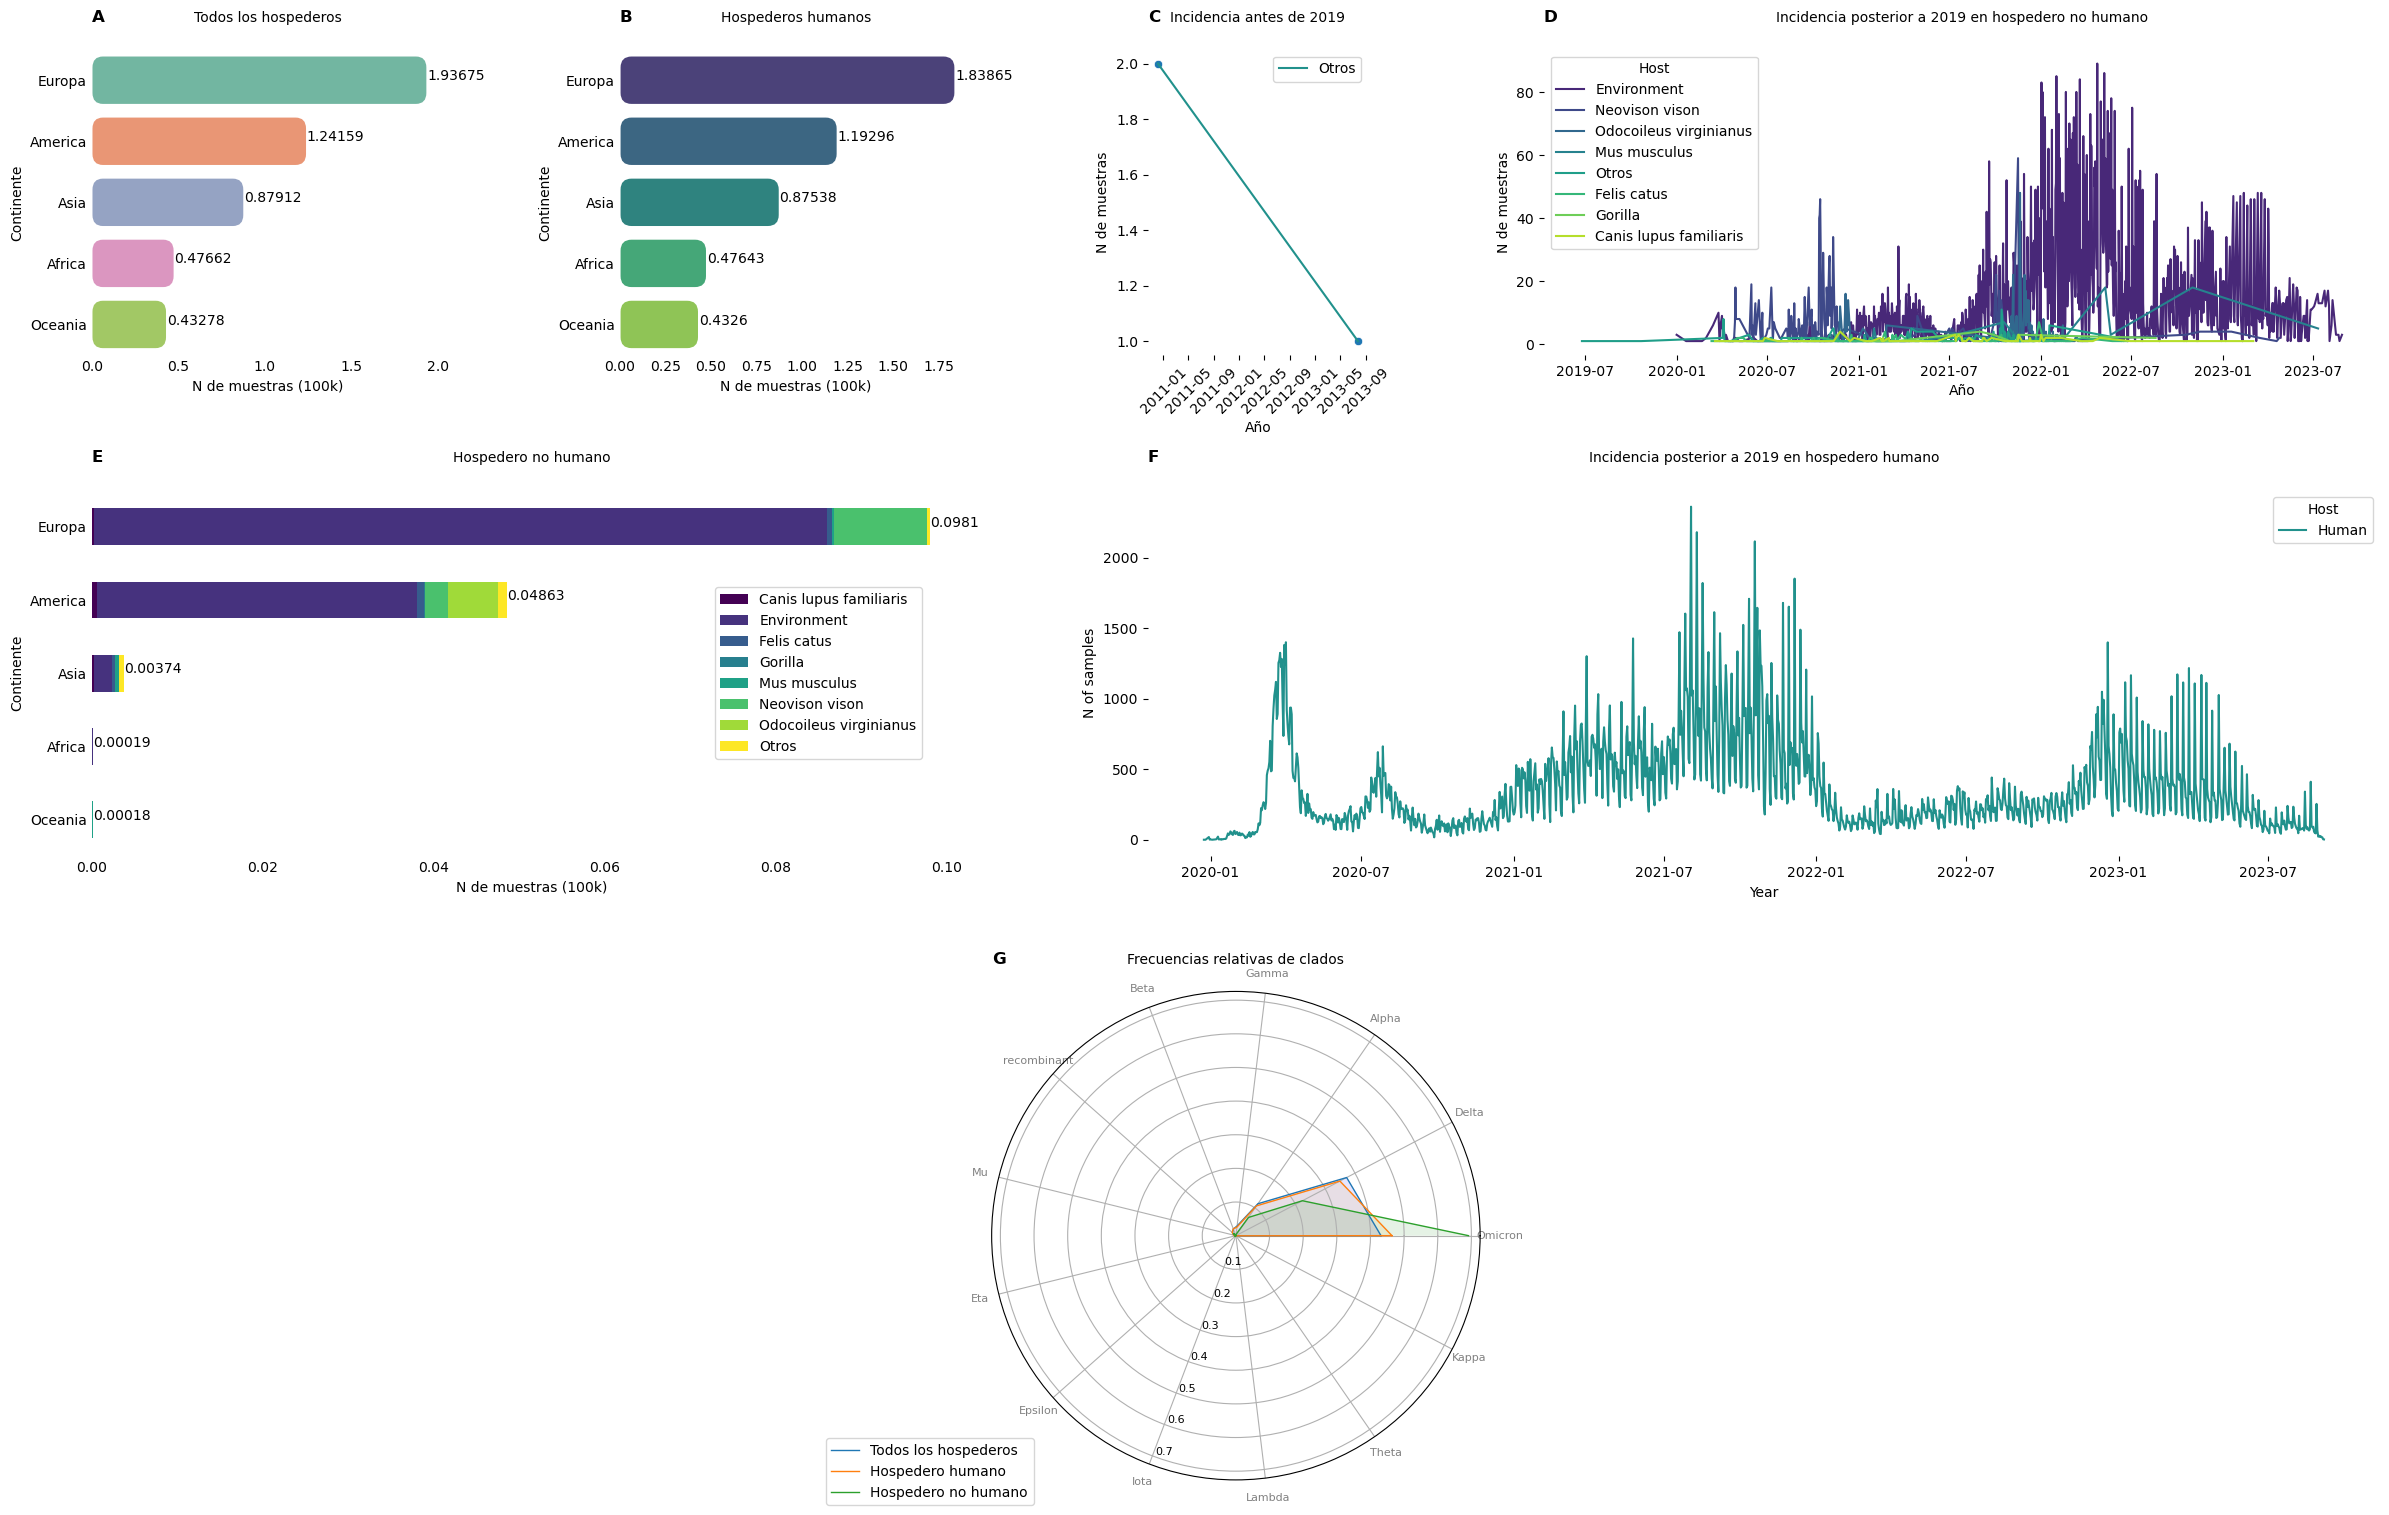

In [22]:
fig = plt.figure(figsize=(24, 15))
gs = gridspec.GridSpec(3, 4, height_ratios=[5, 6,8], width_ratios=[4, 4, 2.5, 9.5])

#===================================== First plot on the top =============================
ax1 = fig.add_subplot(gs[0, 0])
ax1 = sns.barplot(x='count', y='region', data=df_region, palette = 'Set2')
#plt.text(0.05, 1.05, "A", fontweight="bold", transform=plt.gca().transAxes)

ax1.set_title('A', fontweight='bold', loc = 'left')
ax1.set_title('Todos los hospederos', fontsize=10, pad=20)

new_patches = []
for patch in reversed(ax1.patches):
    bb = patch.get_bbox()
    color = patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.0040,rounding_size=0.06",
                            ec="none", fc=color,
                            mutation_aspect=3
                            )
    patch.remove()
    new_patches.append(p_bbox)

for patch in new_patches:
    ax1.add_patch(patch)

# Añade el número correspondiente a cada barra
for i in range(df_region.shape[0]):
    ax1.text(df_region['count'].iloc[i], i,
            df_region['count'].iloc[i], color='black', ha="left")

#delete box
sns.despine(left=True, bottom=True)

# Cambia los nombres de los ejes x e y
plt.xlabel('N de muestras (100k)')
plt.ylabel('Continente')

ax1.tick_params(axis=u'both', which=u'both', length=0)
plt.tight_layout()


#=============================== Second plot on the middle ================================
ax2 = fig.add_subplot(gs[0, 1])
ax2 = sns.barplot(x='count', y='region', data=df_region_host_human, palette = 'viridis', alpha=1)
#plt.text(0.05, 1.05, "B", fontweight="bold", transform=plt.gca().transAxes)
ax2.set_title('B', fontweight='bold', loc = 'left')
ax2.set_title('Hospederos humanos', fontsize=10, pad=20)

new_patches = []
for patch in reversed(ax2.patches):
    bb = patch.get_bbox()
    color = patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.0040,rounding_size=0.06",
                            ec="none", fc=color,
                            mutation_aspect=3
                            )
    patch.remove()
    new_patches.append(p_bbox)

for patch in new_patches:
    ax2.add_patch(patch)

# Añade el número correspondiente a cada barra
for i in range(df_region_host_human.shape[0]):
    ax2.text(df_region_host_human['count'].iloc[i], i,
            df_region_host_human['count'].iloc[i], color='black', ha="left")

#delete box
sns.despine(left=True, bottom=True)

# Cambia los nombres de los ejes x e y
plt.xlabel('N de muestras (100k)')
plt.ylabel('Continente')

ax2.tick_params(axis=u'both', which=u'both', length=0)
plt.tight_layout()

#===================================== Third plot on the top =============================
ax7 = plt.subplot(gs[0, 2])
sns.lineplot(data=freq_2019, x="date", y=0, hue='Host', ax=ax7, palette = 'viridis')
sns.scatterplot(data=freq_2019, x="date", y=0, ax=ax7)

ax7.set_title('C', fontweight="bold", loc = 'left')
ax7.set_title('Incidencia antes de 2019', fontsize=10, pad=20)

ax7.set(xlabel='Año', ylabel='N de muestras')  
plt.xticks(rotation=45)

plt.tight_layout()

#===================================== Four plot on the top =============================
ax8 = plt.subplot(gs[0, 3])
sns.lineplot(data=freq_2020_others, x="date", y=0, hue='Host', ax=ax8, palette = 'viridis')
ax8.set_title('D', fontweight="bold", loc = 'left')

ax8.set(xlabel='Año', ylabel='N de muestras') 
ax8.set_title('Incidencia posterior a 2019 en hospedero no humano', fontsize=10, pad=20)

plt.tight_layout()

#================================ Five plot on the bottom ================================
ax3 = fig.add_subplot(gs[1, 0:2])
b.plot(kind='barh', stacked=True, colormap='viridis', ax=ax3)
plt.legend(loc='center left', bbox_to_anchor=(0.7, 0.5))

plt.title("E", fontweight="bold", loc = 'left')
ax3.set_title('Hospedero no humano', fontsize=10, pad=20)

# Añade el número correspondiente a cada barra
for i in range(x.shape[0]):
    ax3.text(x[0].iloc[i], i,
            round(x[0].iloc[i], 5), color='black', ha="left")

#delete box
sns.despine(left=True, bottom=True)

# Cambia los nombres de los ejes x e y
plt.xlabel('N de muestras (100k)')
plt.ylabel('Continente')

ax3.tick_params(axis=u'both', which=u'both', length=0)


plt.tight_layout()

#===================================== Six plot on the top =============================
ax9 = plt.subplot(gs[1, 2:4])
sns.lineplot(data=freq_2020_human, x="date", y=0, markers=True, dashes=False, hue='Host', ax=ax9, 
            palette = 'viridis')

ax9.set_title('F', fontweight="bold", loc = 'left')
ax9.set_title('Incidencia posterior a 2019 en hospedero humano', fontsize=10, pad=20)

ax9.set(xlabel='Year', ylabel='N of samples') 

sns.despine(left=True, bottom=True)

plt.tight_layout()

#===================================== Nine plot on the top =============================
ax13 = plt.subplot(gs[2, :], polar=True)
plt.xticks(angles[:-1], categories, color='grey', size=8)


# Primer conjunto de datos
ax13.plot(angles, values1, linewidth=1, linestyle='solid', label='Todos los hospederos')
ax13.fill(angles, values1, 'b', alpha=0.1)

# Segundo conjunto de datos
ax13.plot(angles, values2, linewidth=1, linestyle='solid', label='Hospedero humano')
ax13.fill(angles, values2, 'orange', alpha=0.1)

# Tercer conjunto de datos
ax13.plot(angles, values3, linewidth=1, linestyle='solid', label='Hospedero no humano')
ax13.fill(angles, values3, 'green', alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.yticks(fontsize=8)
ax13.set_rlabel_position(250)
ax13.set_title('G', fontweight='bold', loc = 'left')
ax13.set_title('Frecuencias relativas de clados', fontsize=10, pad=20)



# ajustar los espacios entre las graficas
#plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.subplots_adjust(wspace=0.4)
plt.savefig("../../Plots/EpidemiologicSummary.pdf", bbox_inches='tight')

In [23]:
df_pivot.reset_index(inplace = True)
df_pivot['timepoint'] = pd.to_datetime(df_pivot['timepoint'], format='%Y-%m-%d', errors='coerce')
df_pivot.set_index('timepoint', inplace = True)
df_pivot

clone_id,NaN,19A,19B,20A,20B,20C,20D,20E,20F,20G,...,22D,22E,22F,23A,23B,23C,23D,23E,23F,recombinant
timepoint,,,,,,,,,,,,,,,,,,,,,
2010-12-01,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-01,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-01,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-01,0.125000,0.833333,0.041667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,0.168654,0.528109,0.282794,0.018739,NaN,0.001704,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.056662,0.633231,0.188361,0.078101,0.034456,0.007657,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,0.024612,0.199380,0.136804,0.251440,0.160150,0.221068,0.006458,0.000044,0.000044,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-01,0.012425,0.146910,0.055880,0.322259,0.257542,0.194286,0.010631,NaN,0.000066,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df

,strain,virus,gisaid_epi_isl,genbank_accession,date,region,country,division,location,region_exposure,...,title,paper_url,date_submitted,purpose_of_sequencing,año,mes,clade,clade_who,Group,Group_smooth
0,hCoV-19/otter/USA/GA-21-011485-003/2021,betacoronavirus,EPI_ISL_3152719,?,2021-04-16,America,USA,Georgia,NaN,North America,...,?,?,2021-07-30,?,2021.0,4.0,20I,Alpha,"(2021-01-01 00:00:00, 2021-06-01 00:00:00]","(2021-01-01 00:00:00, 2021-05-01 00:00:00]"
1,hCoV-19/otter/USA/GA-21-011485-005/2021,betacoronavirus,EPI_ISL_3152720,?,2021-04-16,America,USA,Georgia,NaN,North America,...,?,?,2021-07-30,?,2021.0,4.0,20I,Alpha,"(2021-01-01 00:00:00, 2021-06-01 00:00:00]","(2021-01-01 00:00:00, 2021-05-01 00:00:00]"
2,hCoV-19/otter/USA/GA-21-011485-007/2021,betacoronavirus,EPI_ISL_3152721,?,2021-04-16,America,USA,Georgia,NaN,North America,...,?,?,2021-07-30,?,2021.0,4.0,20I,Alpha,"(2021-01-01 00:00:00, 2021-06-01 00:00:00]","(2021-01-01 00:00:00, 2021-05-01 00:00:00]"
3,hCoV-19/otter/USA/GA-21-011485-009/2021,betacoronavirus,EPI_ISL_3152722,?,2021-04-16,America,USA,Georgia,NaN,North America,...,?,?,2021-07-30,?,2021.0,4.0,20I,Alpha,"(2021-01-01 00:00:00, 2021-06-01 00:00:00]","(2021-01-01 00:00:00, 2021-05-01 00:00:00]"
4,hCoV-19/otter/USA/GA-21-011485-011/2021,betacoronavirus,EPI_ISL_3152723,?,2021-04-16,America,USA,Georgia,NaN,North America,...,?,?,2021-07-30,?,2021.0,4.0,20I,Alpha,"(2021-01-01 00:00:00, 2021-06-01 00:00:00]","(2021-01-01 00:00:00, 2021-05-01 00:00:00]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496681,hCoV-19/bat/Laos/BANAL-116/2020,betacoronavirus,EPI_ISL_4302646,?,2020-07-07,Asia,Laos,NaN,NaN,Asia,...,?,?,2021-08-27,?,2020.0,7.0,19B,NaN,"(2020-06-01 00:00:00, 2020-09-01 00:00:00]","(2020-03-01 00:00:00, 2020-09-01 00:00:00]"
496682,hCoV-19/bat/Laos/BANAL-236/2020,betacoronavirus,EPI_ISL_4302647,?,2020-07-10,Asia,Laos,NaN,NaN,Asia,...,?,?,2021-08-27,?,2020.0,7.0,19B,NaN,"(2020-06-01 00:00:00, 2020-09-01 00:00:00]","(2020-03-01 00:00:00, 2020-09-01 00:00:00]"
496683,hCoV-19/bat/Laos/BANAL-247/2020,betacoronavirus,EPI_ISL_4302648,?,2020-07-10,Asia,Laos,NaN,NaN,Asia,...,?,?,2021-08-27,?,2020.0,7.0,19B,NaN,"(2020-06-01 00:00:00, 2020-09-01 00:00:00]","(2020-03-01 00:00:00, 2020-09-01 00:00:00]"
496684,hCoV-19/bat/Cambodia/RShSTT182/2010,betacoronavirus,EPI_ISL_852604,?,2010-12-06,Asia,Cambodia,Steung Treng,NaN,Asia,...,?,?,2021-01-20,?,2010.0,12.0,19B,NaN,"(2010-12-05 00:00:00, 2020-01-01 00:00:00]","(2010-12-05 00:00:00, 2020-03-01 00:00:00]"


In [25]:
df_count = df_c.groupby(by = ['timepoint']).sum().reset_index()
df_count['timepoint'] = pd.to_datetime(df_count['timepoint'], format='%Y-%m-%d', errors='coerce')
df_count.head()

,timepoint,year,month,clone_id,count,clonal_prev
0,2010-12-01,2010,12,19B,2,1.0
1,2013-07-01,2013,7,0,1,1.0
2,2019-06-01,2019,6,0,1,1.0
3,2019-10-01,2019,10,19A,1,1.0
4,2019-12-01,6057,36,19A19B,24,1.0


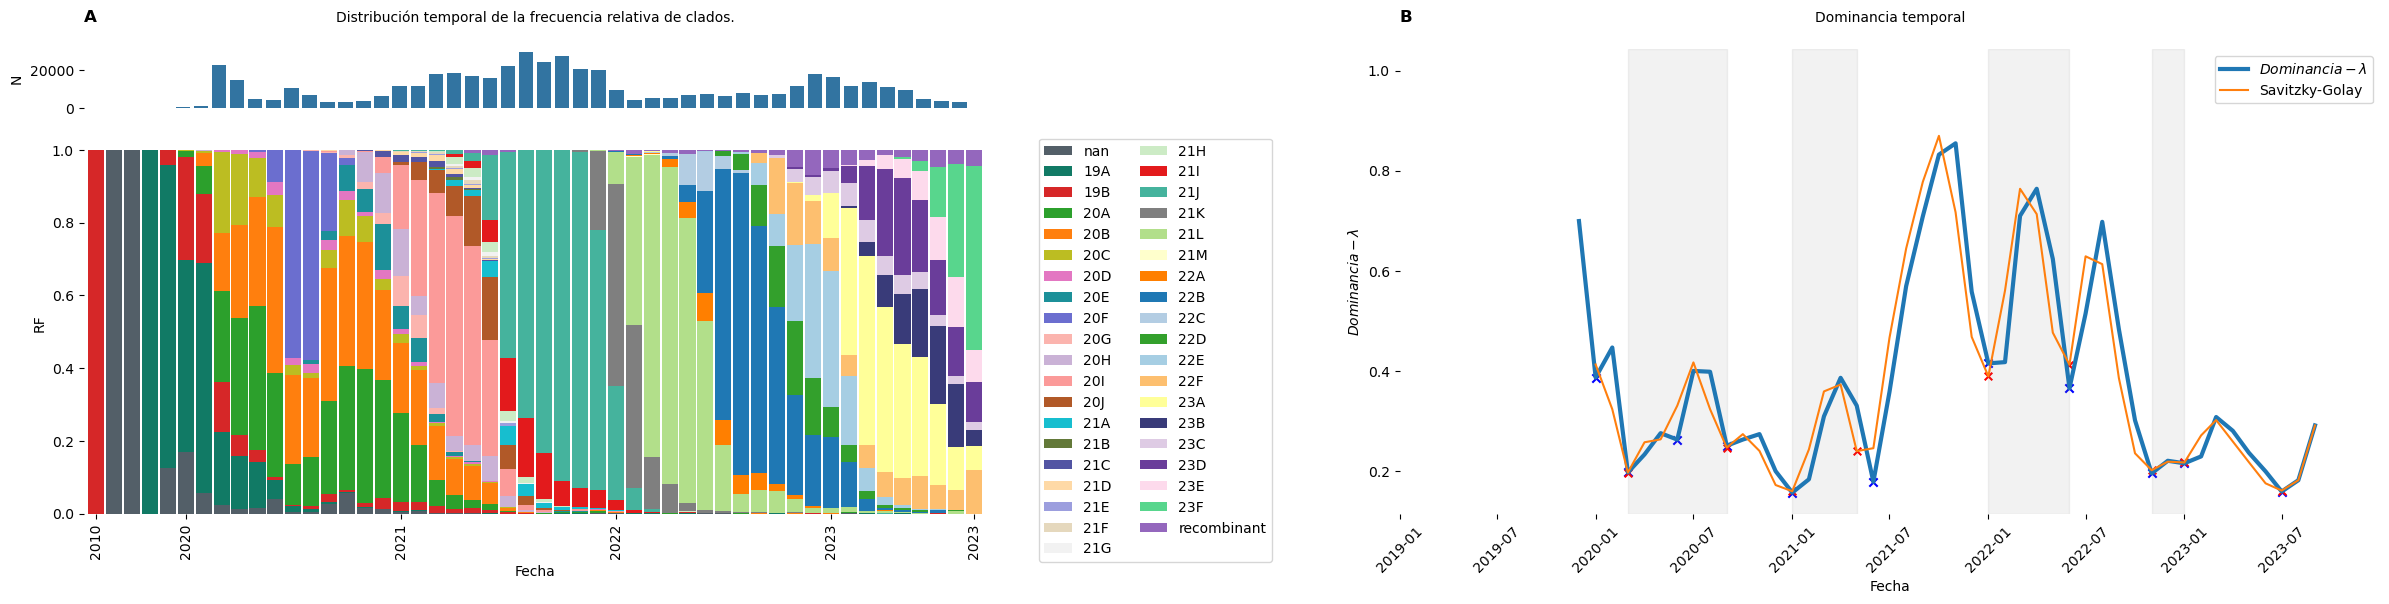

In [26]:
fig = plt.figure(figsize=(24, 6))
gs = gridspec.GridSpec(2, 4, height_ratios=[2, 13], width_ratios=[4, 4, 2.5, 9.5])

#===================================== Seven plot on the top =============================
ax10 = plt.subplot(gs[1, 0:2])

# Crear las barras apiladas con menos separación y colores definidos manualmente
df_pivot.plot(kind='bar', stacked=True, ax=ax10, width=0.9, color=[colores[clade] for clade in df_pivot.columns])

# Configurar las marcas de graduación manualmente
fechas = [pd.Timestamp(fecha) for fecha in ['2010-12-01', '2017-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01', '2023-09-01']]
indices = df_pivot.index.get_indexer(fechas)
valid_indices = indices[indices >= 0]
valid_fechas = [fechas[i] for i in range(len(fechas)) if indices[i] >= 0]

ax10.set_xticks(valid_indices)
ax10.set_xticklabels([fecha.year for fecha in valid_fechas])

# Cambiar el formato de las etiquetas del eje x para que solo muestren el año
#ax10.set_xticklabels([pd.to_datetime(fecha).year for fecha in fechas])
plt.ylabel('RF')
plt.xlabel('Fecha')

plt.legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')

ax1 = plt.subplot(gs[0, 0:2])

sns.barplot(df_count, x="timepoint", y="count", ax = ax1)

# Configurar las marcas de graduación manualmente

ax1.set_xticks([])
ax1.set_xticklabels([])

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Etiquetas y título
plt.ylabel('N')
plt.xlabel('')
#plt.title('RF acumulado por fecha y clade')
# Mover la leyenda a la derecha del gráfico


# Rotar las etiquetas del eje x para una mejor visualización
plt.xticks(rotation=45)

# Quitar el borde del gráfico
for spine in ax10.spines.values():
    spine.set_visible(False)

ax1.set_title('A', fontweight="bold", loc = 'left')
ax1.set_title('Distribución temporal de la frecuencia relativa de clados.', fontsize=10, pad=20)

# Ajustar el layout para que la leyenda no se corte
plt.tight_layout()


#===================================== Eight plot on the top =============================
ax11 = plt.subplot(gs[0:2, 3])

# Dibuja en la subtrama ax11
ax11.scatter(xs.iloc[minima[0]], ys[minima[0]], color='blue', marker='x')
ax11.plot(xs, ys, label=r'$Dominancia-\lambda$', linewidth=3)

ax11.plot(xs, y_smooth, label='Savitzky-Golay')
ax11.scatter(xs.iloc[minima_smooth[0]], y_smooth[minima_smooth[0]], color='red', s=30, marker='x')

ax11.set_xlim([pd.Timestamp(2019,1,1), pd.Timestamp(2023,12,31)])
plt.xticks(rotation=45)

# Dibuja rectángulos grises entre cada mínimo local
for i in range(0, len(minima_smooth[0]) - 1, 2):
    ax11.axvspan(xs.iloc[minima_smooth[0][i]], xs.iloc[minima_smooth[0][i+1]], color='grey', alpha=0.1)


# Elimina los bordes del gráfico
ax11.spines['top'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.spines['bottom'].set_visible(False)
ax11.spines['left'].set_visible(False)

ax11.legend()

# Etiquetas y título
plt.ylabel(r'$Dominancia-\lambda$')
plt.xlabel('Fecha')
ax11.set_title('B', fontweight="bold", loc = 'left')
ax11.set_title('Dominancia temporal', fontsize=10, pad=20)

plt.subplots_adjust(wspace=0.15)
plt.savefig("../../Plots/EpidemiologicDominance2.pdf", bbox_inches='tight')

In [27]:
df_sav = pd.DataFrame({'x': xs, 'ys': ys, 'y_smooth': y_smooth})
df_sav['x'] = pd.to_datetime(df_sav['x'], format='%Y-%m-%d', errors='coerce')
df_sav.drop([0, 1, 2, 3], inplace = True)
df_sav.head()

,x,ys,y_smooth
4,2019-12-01,0.699275,NaN
5,2020-01-01,0.386625,0.412681
6,2020-02-01,0.446597,0.323206
7,2020-03-01,0.196822,0.196565
8,2020-04-01,0.232847,0.257172


In [28]:
df_sav['x'] = df_sav['x'].apply(str)
df_count['timepoint'] = df_count['timepoint'].apply(str)

In [29]:
df_smooth = pd.DataFrame({
    'xs': xs.iloc[minima_smooth[0]],
    'y_smooth': y_smooth[minima_smooth[0]],
})
df_smooth['xs'] = df_smooth['xs'].apply(str)
df_smooth.reset_index(inplace = True)

df_sav_wsmooth = pd.DataFrame({
    'xs': xs.iloc[minima[0]],
    'y_smooth': ys[minima[0]]
})
df_sav_wsmooth['xs'] = df_sav_wsmooth['xs'].apply(str)

df_sav_wsmooth['xs'] = df_sav_wsmooth['xs'].str.split(' ').str[0]
df_smooth['xs'] = df_smooth['xs'].str.split(' ').str[0]
df_count['timepoint'] = df_count['timepoint'].str.split(' ').str[0]
df_sav['x'] = df_sav['x'].str.split(' ').str[0]


df_smooth

,index,xs,y_smooth
0,7,2020-03-01,0.196565
1,13,2020-09-01,0.246523
2,17,2021-01-01,0.159296
3,21,2021-05-01,0.239536
4,29,2022-01-01,0.388870
5,34,2022-06-01,0.412187
6,39,2022-11-01,0.201317
7,41,2023-01-01,0.216809
8,47,2023-07-01,0.160662


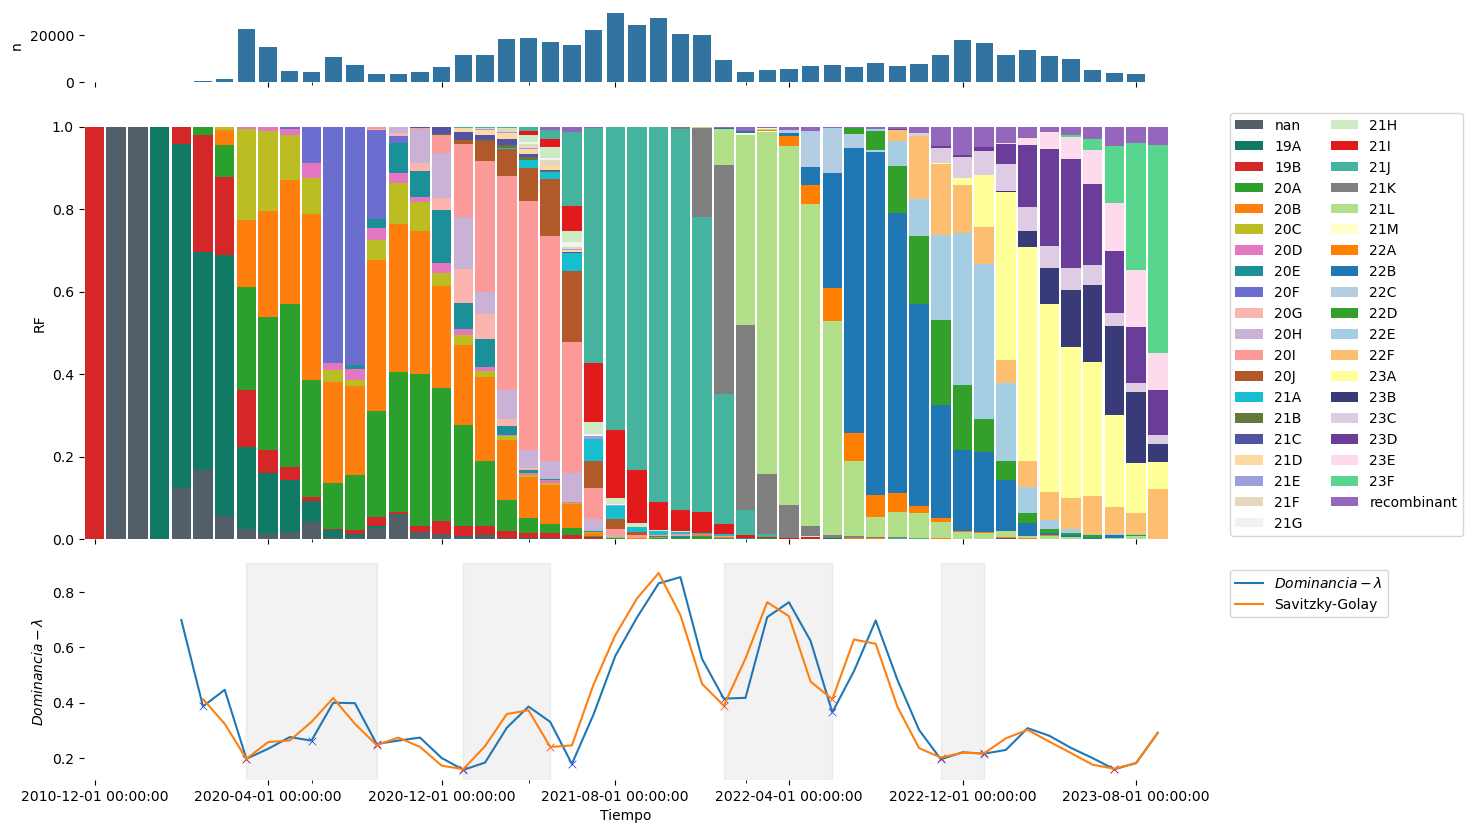

In [32]:
fig, axs = plt.subplots(3, 1, sharex='col', figsize=(14, 10), gridspec_kw={'height_ratios': [1, 6, 3]} ) #, )

df_pivot.plot(kind='bar', stacked=True, ax = axs[1], width=0.9, color=[colores[clade] for clade in df_pivot.columns])

sns.barplot(df_count, x="timepoint", y="count", ax=axs[0])

sns.lineplot(data = df_sav, x = 'x', y = 'ys', ax = axs[2],  label=r'$Dominancia-\lambda$')
sns.lineplot(data = df_sav, x = 'x', y = 'y_smooth', ax = axs[2],  label='Savitzky-Golay')

sns.scatterplot(data = df_sav_wsmooth, x = 'xs', y = 'y_smooth', ax = axs[2],  color='blue', s=30, marker='x')
sns.scatterplot(data = df_smooth, x = 'xs', y = 'y_smooth', ax = axs[2],  color='red', s=30, marker='x')


# Dibuja rectángulos grises entre cada mínimo local
for i in range(0, len(df_smooth) - 1, 2):
    axs[2].axvspan(df_smooth['xs'][i],df_smooth['xs'][i+1], color='grey', alpha=0.1)



axs[1].legend(ncol=2,  bbox_to_anchor=(1.05, 1), loc='upper left')
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axs[1].spines['top'].set_visible(False); axs[1].spines['right'].set_visible(False); axs[1].spines['bottom'].set_visible(False); axs[1].spines['left'].set_visible(False)
axs[2].spines['top'].set_visible(False); axs[2].spines['right'].set_visible(False); axs[2].spines['bottom'].set_visible(False); axs[2].spines['left'].set_visible(False)
axs[0].spines['top'].set_visible(False); axs[0].spines['right'].set_visible(False); axs[0].spines['bottom'].set_visible(False); axs[0].spines['left'].set_visible(False)


for ax in axs: 
    ax.set_xticks(ax.get_xticks()[::2])


axs[0].set_ylabel('n')
axs[1].set_ylabel('RF')
axs[2].set_ylabel(r'$Dominancia-\lambda$')

axs[2].set_xlabel('Tiempo')


plt.subplots_adjust(hspace=0.1)

plt.savefig("../../Plots/EpidemiologicDominance3.pdf", bbox_inches='tight')